In [13]:
!pip install --upgrade tensorflow

In [14]:
import os
# Pythonのosモジュールを使用し、環境変数KERAS_BACKENDの値を"jax"にして
# KerasのバックエンドをJAXに設定
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import ops

import numpy as np
import matplotlib.pyplot as plt


In [15]:
# 分類先のクラスの数
num_classes = 100
# 画像1枚の形状
input_shape = (32, 32, 3)
# CFAR-100データセットをダウンロード
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
# トレーニングデータの形状と正解ラベルの形状を出力
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# テストデータの形状と正解ラベルの形状を出力
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [16]:
learning_rate = 0.001 # 学習率
weight_decay = 0.0001 # 重み減衰の強度を設定
batch_size = 256 # ミニバッチのサイズ
num_epochs = 50  # 学習回数(エポック数)
image_size = 72  # 入力画像を事前に拡大するサイズ
patch_size = 6  # パッチ1辺のサイズ
num_patches = (image_size // patch_size) ** 2 # パッチ数を取得
projection_dim = 64 # 位置情報として埋め込むベクトルの次元数
num_heads = 4 # Multi-Head Self-Attentionのヘッド数
# MLP隠れ層、2層それぞれのユニット数
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
# Transformer(Encoder)ブロックの数
transformer_layers = 8
# クラス分類を行うMLPの隠れ層、2層それぞれのユニット数
mlp_head_units = [
    2048,
    1024,
]


In [17]:
data_augmentation = tensorflow.keras.Sequential(
    [
        layers.Normalization(), # データの平均と標準偏差を用いて標準化
        layers.Resizing(image_size, image_size), # 画像をimage_sizeにリサイズ
        layers.RandomFlip("horizontal"), # ランダムに左右反転
        layers.RandomRotation(factor=0.02), # ランダムに係数0.02の割合で回転
        layers.RandomZoom(height_factor=0.2, width_factor=0.2), # 係数0.2の割合で拡大/縮小
    ],
    name="data_augmentation", # 処理に名前を付ける
)

# data_augmentationの標準化レイヤー（layers[0]）をトレーニングデータx_trainに適用する
data_augmentation.layers[0].adapt(x_train)


In [18]:
def mlp(x, hidden_units, dropout_rate):
    """多層パーセプトロンを構築する関数

    Args:
        x: 画像のデータセット
        hidden_units(list): 隠れ層のユニット数を格納したリスト
        dropout_rate(float): ドロップアウト率
    """
    # 指定されたユニットの数だけループして隠れ層を生成
    for units in hidden_units:
        # 活性化関数GELUを適用
        x = layers.Dense(units, activation=tensorflow.keras.activations.gelu)(x)
        # ドロップアウトを適用して出力
        x = layers.Dropout(dropout_rate)(x)
    return x


In [19]:
class Patches(layers.Layer):
    """パッチに分割する処理をレイヤーとして定義

    Attributes:
        patch_size(int): パッチ1辺のサイズ
    """
    def __init__(self, patch_size):
        """パッチ1辺のサイズをインスタンス変数に格納

        Args:
            patch_size(int): パッチ1辺のサイズ
        """
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        """
        Args:
            images: 画像のデータセット
        """
        # 画像データセットの形状を取得 --->(bs, 72, 72, 3)
        input_shape = ops.shape(images)
        batch_size = input_shape[0] # ミニバッチのサイズを取得  --->256
        height = input_shape[1] # 画像の高さを取得  --->72
        width = input_shape[2] # 画像の幅を取得  --->72
        channels = input_shape[3] # 画像のチャンネル数を取得  --->3
        # 画像の高さをパッチサイズで除算し、縦方向のパッチ数を求める
        num_patches_h = height // self.patch_size # --->72÷6＝12
        # 画像の幅をパッチサイズで除算し、横方向のパッチ数を求める
        num_patches_w = width // self.patch_size # --->72÷6＝12
        # ops.extract_patches関数を使用して、入力画像からパッチを抽出
        # sizeオプションにパッチ1辺のサイズ(6)を設定
        # 72×72×3を6×6のパッチに分割、元の画像は縦12、横12に分割される
        # パッチ1個あたりの特徴量次元は6×6×3(チャンネル)＝108
        # (bs, 72, 72, 3)--->(bs, 12, 12, 108)
        patches = tensorflow.keras.ops.image.extract_patches(
            images, size=self.patch_size)
        # ops.reshape関数を使用して、抽出されたパッチの縦と横の次元を結合してフラット化
        # 12(パッチの縦の次元数)×12(パッチの横の次元数)＝144(パッチの数に相当)
        # (bs, 12, 12, 108)--->(bs, 144, 108)
        patches = ops.reshape(
            patches,
            # 新しい形状をタプルで指定
            (
                # ミニバッチのサイズを保持する次元
                batch_size,
                # 抽出されたすべてのパッチを保持する次元
                # 12×12＝144
                num_patches_h * num_patches_w,
                # 1枚の画像から抽出されたすべてのパッチをフラット化する次元
                # 6×6×3＝108
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        """レイヤーの設定（config）を取得
        """
        config = super().get_config()
        # レイヤーの設定にpatch_sizeというキーでself.patch_sizeの値を登録
        # これにより、後でこのレイヤーを再構築する際に、patch_sizeの値が保持される
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


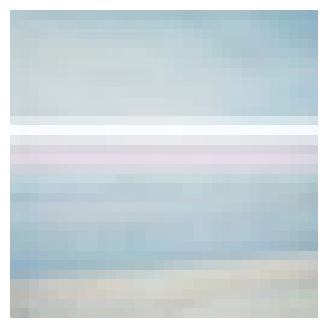

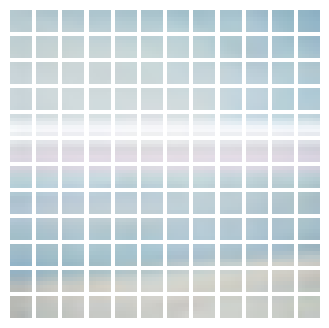

In [20]:
# グラフエリアのサイズは4x4インチ
plt.figure(figsize=(4, 4))
# x_trainからランダムに画像1枚を抽出、テンソルの形状は(32, 32, 3)
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8")) # 画像を表示
plt.axis("off") # 軸を非表示にする
# 画像を指定されたサイズにリサイズ、テンソルの形状は(1, 72, 72, 3)
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
# リサイズされた画像をPatchesでパッチに分割
# patchesの形状は(1, 144, 108)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}") # 画像のサイズ
print(f"Patch size: {patch_size} X {patch_size}") # パッチのサイズ
print(f"Patches per image: {patches.shape[1]}")   # 画像1枚当たりのパッチ数
print(f"Elements per patch: {patches.shape[-1]}") # パッチの要素数

n = int(np.sqrt(patches.shape[1])) # パッチ数の平方根を計算
plt.figure(figsize=(4, 4)) # 新しい図のサイズを設定
# パッチの数だけループ
for i, patch in enumerate(patches[0]):
    # グリッド内の特定の位置にサブプロットを作成し変数axに格納
    ax = plt.subplot(n, n, i + 1)
    # パッチを画像の形状に変形
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    # パッチを表示
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off") # 軸を非表示にする


In [21]:
class PatchEncoder(layers.Layer):
    """各パッチを低次元の空間に射影し、位置情報を埋め込んで
       特徴マップを生成する

    Attributes:
        num_patches(int): パッチの数
        projection(object): パッチデータを低次元の空間に射影する全結合層
        position_embedding(object): 位置情報の埋め込みを行うEmbedding層
    """
    def __init__(self, num_patches, projection_dim):
        """パッチの特徴を低次元の空間に射影するための全結合層と
           各パッチの位置情埋め込むEmbedding層を定義

        Args:
            num_patches(int): パッチの数
            projection_dim(int): 位置情報として埋め込むベクトルの次元数(64)
        """
        super().__init__()
        self.num_patches = num_patches #  パッチの数(144)
        # パッチの特徴を低次元の空間に射影するための全結合層を定義(64ユニット)
        self.projection = layers.Dense(units=projection_dim)
        # 各パッチの位置情報を学習可能な埋め込みベクトルで表現するEmbedding層を定義
        # 入力特徴量の次元数144、出力の次元数64とし、パッチデータのサイズと合わせる
        # 入力テンソルが(1, 144)の場合、出力されるテンソルの形状は (1, 144, 64)
        # 144個の各パッチ(64次元)に対し、位置情報として64次元の埋め込みベクトルが生成される
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, # 入力データの次元数＝パッチの数(144)
            output_dim=projection_dim # 出力の次元数、つまり埋め込みベクトルの次元数(64)
        )

    def call(self, patch):
        """PatchEncoderのインスタンスが呼び出されるときに実行される
        与えられたパッチを低次元の空間に射影し、位置情報を埋め込む

        Args:
            patch: 1個のパッチデータ(bs, 144, 108)
        """
        # 各パッチの位置情報として、0からself.num_patches(パッチ数)まで1刻みの数列を生成
        # テンソルの形状は(1, 144)でパッチの数に合わせる
        positions = ops.expand_dims(
            # [0, 1, 2, ..., 143]という形状(144,)の1階テンソルを生成
            ops.arange(start=0, stop=self.num_patches, step=1),
            # 新しい次元を先頭のの軸として追加して、2階テンソル(1, 144)にする
            axis=0
        )
        # 全結合層を使用して、入力パッチを低次元の空間に射影
        # (bs, 144, 108)--->(bs, 144, 64)
        projected_patches = self.projection(patch)
        # 全結合層の出力にパッチの位置埋め込みを適用
        # パッチのテンソル(bs, 144, 64)に対してEmbedding層の出力 (1, 144, 64)を「加算」します。
        # 結果、テンソルの形状は(bs, 144, 64)で変わりはありませんが、
        # 要素の値は「位置情報が加算」、つまり「位置情報の埋め込み」が行われた状態になります。
        encoded = projected_patches + self.position_embedding(positions)

        return encoded

    def get_config(self):
        """レイヤーの設定（config）を取得するためのメソッド

        """
        config = super().get_config()
        # レイヤーの設定にnum_patchesというキーでself.num_patchesの値を追加または更新
        config.update({"num_patches": self.num_patches})
        return config


In [22]:
def create_vit_classifier():
    """ViTモデルを生成する

    """
    # 入力層を定義、入力の形状は(bs, 32, 32, 3)
    inputs = tensorflow.keras.Input(shape=input_shape)
    # 入力データにデータ拡張を適用 --->(bs, 72, 72, 3)
    augmented = data_augmentation(inputs)
    # パッチに分割するレイヤーをインスタンス化してデータ拡張後の画像をパッチに分割
    # パッチサイズ6の場合は12×12＝144パッチに分割
    # 1個のパッチサイズは6×6×3(チャンネル)＝108
    # (bs, 144, 108)のテンソルが返される
    patches = Patches(patch_size)(augmented)
    # PatchEncoder層をインスタンス化し、パッチデータを入力
    # パッチデータは低次元の空間に射影されて位置情報が埋め込まれる
    # (bs, 144, 108)--->(bs, 144, 64)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Encoderブロックの処理をtransformer_layersの数(8)だけ繰り返す
    for _ in range(transformer_layers):
        # 位置情報が埋め込まれたパッチに対して正規化を適用
        # epsilonは数値安定性のための小さな定数
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-Head Self-Attention層を生成
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, # ヘッドの数(4)
            key_dim=projection_dim, # 各ヘッドのキーの次元数＝埋め込み層の次元数(64)
            dropout=0.1 # ドロップアウト率
        )(query=x1, value=x1, key=x1) # query、value、keyをMultiHeadAttentionレイヤーに渡す
                                      # keyが明示的に指定されない場合、valueがkeyとして使用される
        # スキップ接続（残差接続）を追加し、Attention出力とエンコードされたパッチを加算
        x2 = layers.Add()([attention_output, encoded_patches])
        # 再度、正規化を適用
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP（多層パーセプトロン）を適用
        x3 = mlp(x3,
                 hidden_units=transformer_units, # MLP隠れ層のユニット数
                 dropout_rate=0.1) # ドロップアウト率
        # もう一度スキップ接続を追加し、MLP出力に前の層の出力を加算する
        encoded_patches = layers.Add()([x3, x2])

    # エンコードされたパッチに対してレイヤー正規化を適用
    # (bs, 144, 64)--->(bs, 144, 64)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # 正規化された出力をフラットにする
    # (bs, 144, 64)--->(bs, 9216)
    representation = layers.Flatten()(representation)
    # ドロップアウト率0.5を適用
    representation = layers.Dropout(0.5)(representation)
    # MLPヘッドを適用します。mlp_head_unitsはMLPヘッドの隠れユニット数、
    # dropout_rateはドロップアウト率
    # (bs, 9216)--->(bs, 1024)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # 出力層を追加、ユニット数はnum_classes(クラス数100)
    # (bs, 1024)--->(bs, 100)
    logits = layers.Dense(num_classes)(features)
    # 入力テンソルinputsと出力テンソルlogitsを使用して、モデルを生成
    model = tensorflow.keras.Model(inputs=inputs, outputs=logits)

    return model


In [23]:
def run_experiment(model):
    """Vision Transformer (ViT) モデルをトレーニングし、性能を評価する

    Args:
        model: ViTモデルのオブジェクト
    """
    # AdamWオプティマイザーをインスタンス化
    # AdamWはAdamオプティマイザーに重み減衰を加えたもの
    optimizer = tensorflow.keras.optimizers.AdamW(
        learning_rate=learning_rate, # 学習率 (learning_rate)を設定
        weight_decay=weight_decay # 重みの減衰率 (weight_decay) を設定
    )
    # モデルをコンパイル
    model.compile(
        optimizer=optimizer,
        # 損失関数にSparseCategoricalCrossentropyを指定
        # この関数は多クラス分類問題でラベルが整数値として与えられる場合に使用できる
        loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        # 評価指標として、SparseCategoricalAccuracy（全体の分類精度）と
        # SparseTopKCategoricalAccuracy（トップ5の分類精度）を設定
        metrics=[
            tensorflow.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tensorflow.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # モデルの重みを保存するためのチェックポイントファイルのパスを設定
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    # 1エポックごとに呼び出されるコールバックとしてModelCheckpointを作成
    # ModelCheckpointは、検証精度（val_accuracy）が最も高いモデルの
    # 重みを保存することで、最良のモデルのみを保存するように設定されている
    checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    # モデルのトレーニング
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size, # ミニバッチのサイズ
        epochs=num_epochs, # エポック数
        validation_split=0.1, # データの10%を検証データとして使用
        callbacks=[checkpoint_callback], # ModelCheckpointをコールバックする
    )

    # 保存された最良のモデルの重みをロード
    model.load_weights(checkpoint_filepath)
    # テストデータ（x_test, y_test）を使用してモデルを評価
    # 全体の分類精度（accuracy）とトップ5の分類精度（top_5_accuracy）を取得
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # テストデータに対する精度を表示
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # テストデータに対するトップ5の精度を表示
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    # トレーニングの履歴（history）を返す。これには、各エポックでの評価指標が含まれる
    return history

def plot_history(item):
    """トレーニング履歴をプロットする関数

    Args:
        item(str): トレーニング履歴から抽出するデータを示す文字列(キー)
    """
    # history.history辞書からitem に対応するトレーニングデータの履歴を取得してプロット
    plt.plot(history.history[item], label=item)
    # history.history 辞書から"val_" + item に対応する検証データの履歴を取得してプロット
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend() # プロットに凡例を追加
    plt.grid() # プロットにグリッド線を追加
    plt.show()


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.0305 - loss: 4.8983 - top-5-accuracy: 0.1110 - val_accuracy: 0.0936 - val_loss: 4.0055 - val_top-5-accuracy: 0.2966
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.0813 - loss: 4.0315 - top-5-accuracy: 0.2591 - val_accuracy: 0.1660 - val_loss: 3.5668 - val_top-5-accuracy: 0.4264
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.1263 - loss: 3.7015 - top-5-accuracy: 0.3637 - val_accuracy: 0.1998 - val_loss: 3.3204 - val_top-5-accuracy: 0.4846
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.1605 - loss: 3.5009 - top-5-accuracy: 0.4232 - val_accuracy: 0.2338 - val_loss: 3.1347 - val_top-5-accuracy: 0.5266
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.1906 - loss: 3.3302 - top-5-accuracy: 0.4713 - val_accuracy: 0.2614 - val_loss: 2.9856 - val_top-5-accuracy: 0.5668
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.2268 - loss: 3.155

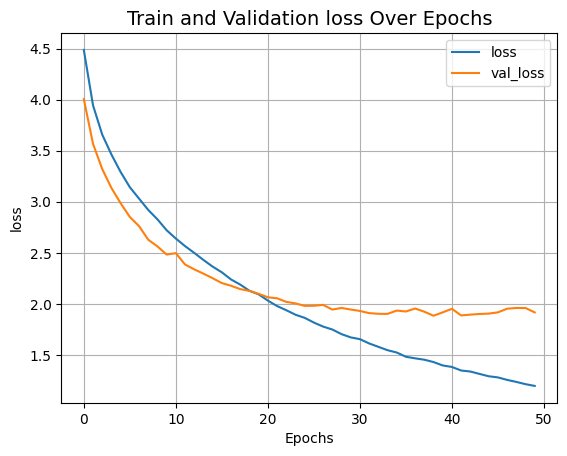

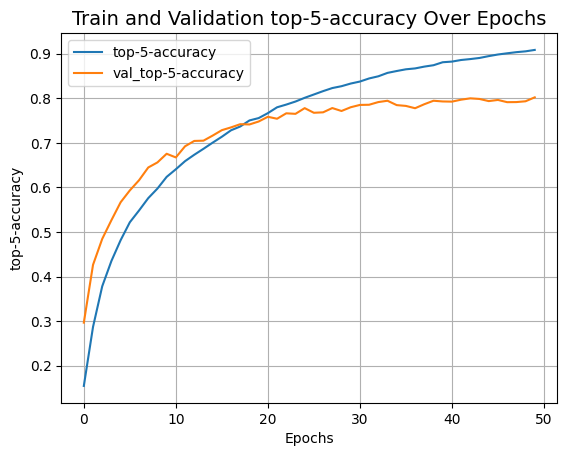

CPU times: user 3h 32min 4s, sys: 36min 10s, total: 4h 8min 15s
Wall time: 3h 19min 25s


In [24]:
%%time

# ViTモデルをインスタンス化
vit_classifier = create_vit_classifier()
# ViTモデルを引数にしてrun_experiment()を実行し、モデルのトレーニングと評価を行う
history = run_experiment(vit_classifier)

# トレーニング履歴の損失（loss）とトップ5精度（top-5-accuracy）をプロット
plot_history("loss")
# トレーニング履歴の損失（loss）とトップ5精度（top-5-accuracy）をプロット
plot_history("top-5-accuracy")
